In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import shutil
import glob

In [2]:
ROOT_DIR = "ModelTraining/dataset"
number_of_images = {}

for dir in os.listdir(ROOT_DIR):
    number_of_images[dir] = len(os.listdir(os.path.join(ROOT_DIR, dir)))

number_of_images.items()

dict_items([('healthy', 2000), ('tumor', 5023)])

In [3]:
def dataFolder(path, split):
    if not os.path.exists("./"+path):
        os.mkdir("./"+path)

        for dir in os.listdir(ROOT_DIR):
            os.makedirs("./"+path+"/"+dir)

            for img in np.random.choice(a = os.listdir(os.path.join(ROOT_DIR, dir)),
                                        size = (math.floor(split*number_of_images[dir])-2),
                                        replace = False):
                O = os.path.join(ROOT_DIR,dir,img)
                D = os.path.join("./"+path, dir)
                shutil.copy(O,D)
                os.remove(O)
    else:
        print(f"{path} folder exists")

In [4]:
dataFolder("ModelTraining/train", 0.7)
dataFolder("ModelTraining/val", 0.15)
dataFolder("ModelTraining/test", 0.15)

ModelTraining/train folder exists
ModelTraining/val folder exists
ModelTraining/test folder exists


# Model Build

In [5]:
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAvgPool2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import keras

In [6]:
model = Sequential()

model.add(Conv2D(filters = 16, kernel_size= (3,3), activation='relu',
                 input_shape = (224,224,3)))

model.add(Conv2D(filters = 36, kernel_size= (3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 64, kernel_size= (3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 128, kernel_size= (3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Dropout(rate = 0.25))

model.add(Flatten())
model.add(Dense(units = 64, activation='relu'))
model.add(Dropout(rate = 0.25))
model.add(Dense(units = 1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 36)      5220      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 36)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 64)      20800     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 52, 52, 128)       7

In [7]:
model.compile(optimizer='adam',
              loss= keras.losses.binary_crossentropy,
              metrics=['accuracy'])

In [8]:
def preprocessingImages1(path):
    image_data = ImageDataGenerator(zoom_range = 0.2, shear_range = 0.2, 
                                    rescale = 1/255, horizontal_flip = True)
    image = image_data.flow_from_directory(directory = path, 
                                           target_size= (224,224), 
                                           batch_size = 32, 
                                           class_mode='binary')
    
    return image

In [9]:
path = "ModelTraining/train"
train_data = preprocessingImages1(path)

Found 4912 images belonging to 2 classes.


In [10]:
def preprocessingImages2(path):
    image_data = ImageDataGenerator(rescale = 1/255)
    image = image_data.flow_from_directory(directory = path, 
                                           target_size= (224,224), 
                                           batch_size = 32, 
                                           class_mode='binary')
    
    return image

In [11]:
path = "ModelTraining/test"
test_data = preprocessingImages2(path)

Found 1049 images belonging to 2 classes.


In [12]:
path = "ModelTraining/val"
val_data = preprocessingImages2(path)

Found 1049 images belonging to 2 classes.


In [13]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

es = EarlyStopping(monitor = "val_accuracy", 
                   min_delta = 0.01, 
                   patience = 6, 
                   verbose = 1, 
                   mode = 'auto')

mc = ModelCheckpoint(monitor = "val_accuracy",
                     filepath = "./ModelTraining/braintumordetectionmodel.h5", 
                     mode = 'auto', 
                     verbose = 1, 
                     save_best_only = True)

cd = [es,mc]

In [14]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Model Training

In [15]:
hs = model.fit(train_data, 
               steps_per_epoch= 8, 
               epochs = 300,
               verbose = 1,
               validation_data = val_data,
               validation_steps = 16,
               callbacks = cd)

Epoch 1/300
8/8 [==============================] - ETA: 0s - loss: 0.7678 - accuracy: 0.6172
Epoch 1: val_accuracy improved from -inf to 0.72266, saving model to ./ModelTraining\braintumordetectionmodel.h5
8/8 [==============================] - 13s 583ms/step - loss: 0.7678 - accuracy: 0.6172 - val_loss: 0.6159 - val_accuracy: 0.7227
Epoch 2/300
8/8 [==============================] - ETA: 0s - loss: 0.6125 - accuracy: 0.7461
Epoch 2: val_accuracy did not improve from 0.72266
8/8 [==============================] - 6s 689ms/step - loss: 0.6125 - accuracy: 0.7461 - val_loss: 0.5444 - val_accuracy: 0.7031
Epoch 3/300
8/8 [==============================] - ETA: 0s - loss: 0.4968 - accuracy: 0.7617
Epoch 3: val_accuracy improved from 0.72266 to 0.88281, saving model to ./ModelTraining\braintumordetectionmodel.h5
8/8 [==============================] - 5s 639ms/step - loss: 0.4968 - accuracy: 0.7617 - val_loss: 0.3938 - val_accuracy: 0.8828
Epoch 4/300
8/8 [==============================] - ET

In [16]:
h = hs.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

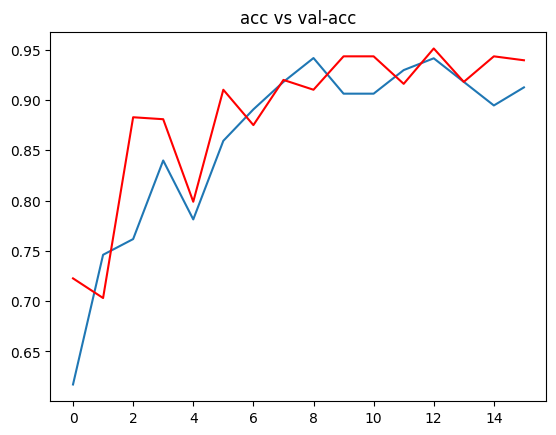

In [17]:
import matplotlib.pyplot as plt

plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'], c = "red")

plt.title("acc vs val-acc")
plt.show()

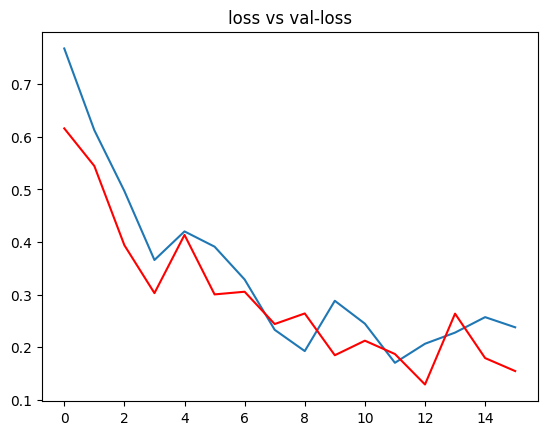

In [18]:
import matplotlib.pyplot as plt

plt.plot(h['loss'])
plt.plot(h['val_loss'], c = "red")

plt.title("loss vs val-loss")
plt.show()

# Model Accuracy

In [19]:
from keras.preprocessing.image import ImageDataGenerator
def preprocessingImages2(path):
    image_data = ImageDataGenerator(rescale = 1/255)
    image = image_data.flow_from_directory(directory = path, 
                                           target_size= (224,224), 
                                           batch_size = 32, 
                                           class_mode='binary')
    
    return image

In [20]:
from keras.models import load_model

model = load_model("ModelTraining/braintumordetectionmodel.h5")
path = "ModelTraining/test"
test_data = preprocessingImages2(path)
acc = model.evaluate(test_data)[1]
print(f"Accuracy of model is {acc*100}%")

Found 1049 images belonging to 2 classes.
33/33 [==============================] - 4s 115ms/step - loss: 0.1963 - accuracy: 0.9276
Accuracy of model is 92.75500774383545%


In [21]:
from keras.models import load_model

model = load_model("model.h5")
path = "ModelTraining/test"
test_data = preprocessingImages2(path)
acc = model.evaluate(test_data)[1]
print(f"Accuracy of model is {acc*100}%")

Found 1049 images belonging to 2 classes.
33/33 [==============================] - 3s 75ms/step - loss: 0.2185 - accuracy: 0.9209
Accuracy of model is 92.08770394325256%


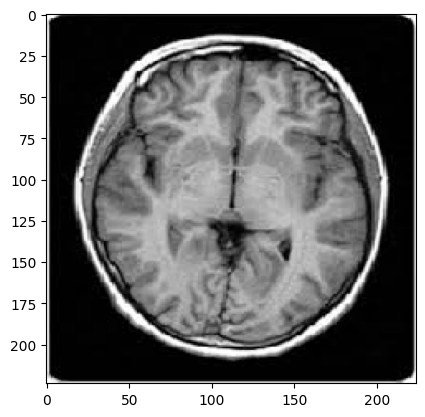

1/1 [==============================] - 0s 408ms/step
This MRI is of healthy brain.


In [22]:
from tensorflow.keras.utils import load_img, img_to_array
import matplotlib.pyplot as plt
import numpy as np

path = "20 no.jpg"

img = load_img(path, target_size = (224,224))
input_arr = img_to_array(img)/255

plt.imshow(input_arr)
plt.show()

input_arr = np.expand_dims(input_arr,axis = 0)

prediction=(model.predict(input_arr) > 0.5).astype("int32")[0][0]
prediction

if prediction == 1:
    print("This MRI have brain tumor.")
else:
    print("This MRI is of healthy brain.")